# Read files

In [1]:
# import libraries
import numpy as np
import pandas as pd
import os, h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
from jason import jason_plotting as plotting
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('/Users/jasonwu/Programs/codes/def.mplstyle')
plotting.plot_prettier(dpi=400,usetex=False)
%matplotlib inline

In [2]:
# global variables
ECALZ_MIN = 247.9
ECALZ_MAX = 749.1
ECALW = 260

HCALZ_MIN = 879

# the style used for the confidence range plots
# 0: area
# 1: error bars
style = 1

# Loading the Particles

## Class

In [3]:
labels_keys = 'electron neutron photon pion proton electron_hcal neutron_hcal photon_hcal pion_hcal proton_hcal'.split(' ')
labels_values = [
    r'Electrons $e^{\minus}$',
    r'Neutrons $n^{o}$',
    r'Photons $\gamma$',
    r'Pions $\pi^{\minus}$',
    r'Protons $p^{\plus}$',
    r'Electrons $e^{\minus}$ HCal',
    r'Neutrons $n^{o}$ HCal',
    r'Photons $\gamma$ HCal',
    r'Pions $\pi^{\minus}$ HCal',
    r'Protons $p^{\plus}$ HCal'
]

labels_dict = {labels_keys[i]: labels_values[i] for i in range(len(labels_keys))}

In [4]:
# initiate a particle class
class Particles():
    def __init__(self, hf, zero_on='PFTruthTarget_energy'):
        # a list of properties
        self.propdict = {}
        # initiate all properties
        for prop in hf.keys():
            # convert to numpy array
            self.propdict[prop] = hf[prop][()]
        self._clean_props(zero_on)
    
    # clean the data set
    def _clean_props(self, zero_on='PFTruthTarget_energy'):
        # remove on column
        if isinstance(zero_on, list):
            # invalid energy values
            zero_bool_mask = np.array(self.propdict[zero_on[0]] <= 0)
            for zero_col in zero_on[1:]:
                zero_bool_mask = np.logical_and(zero_bool_mask, np.array(self.propdict[zero_col] <= 0))
        else:
            zero_bool_mask = np.array(self.propdict[zero_on] <= 0)
            
        print(f'{np.sum(zero_bool_mask)} values removed from {zero_on}')
        
        for prop in list(self.propdict.keys()):
            nan_bool_mask = np.isnan(self.propdict[prop])
            if np.any(nan_bool_mask):
                print(f'{np.sum(nan_bool_mask):<10} NaN values for {prop}')
                # set the values to zero
                self.propdict[prop][np.isnan(self.propdict[prop])] = 0
            self.propdict[prop] = self.propdict[prop][~zero_bool_mask]
                
        print('\n')
    
    # return a property
    def get(self, prop = None):
        if prop is not None:  # if specific property(ies) are given
            if isinstance(prop, list):
                prop_list = []
                for single_prop in prop:
                    prop_list.append(self.propdict[single_prop])
                return prop_list
            else:
                assert prop in list(self.propdict.keys())
                return self.propdict[prop]
        else:
            return self.propdict
    
    # account for mass of particle
    def acc_mass(self, mass, columns=[]):
        # subtract mass
        for column in columns:
            self.propdict[column] = np.clip(self.propdict[column] - mass, 0, None)
    
    # return a list of all properties
    def list_props(self):        
        print(f'{"Property Name":<30}{"Number of Entries":<20}{"Unique Entries":<20}{"Range":<30}{"Mean"}')
        
        for prop in list(self.propdict.keys()):
            print(f'{prop: <30}{len(self.propdict[prop]):<20}{len(np.unique(self.propdict[prop])):<8}\
            {np.min(self.propdict[prop]):<10.2f}{np.max(self.propdict[prop]):>8.2f}\
            {np.mean(self.propdict[prop]):<.2f}')
        print('\n')
        return list(self.propdict.keys())
    
    # apply a correction to the ecal and hcal energy measurements
    def o1corr_energy(self, verbose=True, scheme='nearest',  # three schemes 'none', 'nearest' and 'spline'
                      energy_bins_ecal=[0, 6e3], o1corr_ecal=[1],
                      energy_bins_hcal=[0, 6e3], o1corr_hcal=[1],
                      numbins=20, gev=True, label=labels_dict['photon']):
        # correct the energies
        match scheme:  # different schemes to handle values outside of measured bins
            case 'none':  # set to NaN, breaks plots
                # ecal
                o1corr_ecal = pd.cut(self.get('PFCandidates_ecalEnergy'), bins=energy_bins_ecal,
                                     include_lowest=True, labels=o1corr_ecal).to_numpy()
                # hcal
                o1corr_hcal = pd.cut(self.get('PFCandidates_hcalEnergy'), bins=energy_bins_hcal,
                                     include_lowest=True, labels=o1corr_hcal).to_numpy()
            case 'nearest':  # sets to value of nearest bin
                def nearest_cut(data, bins=[0, 6e3], labels=[1]):
                    # assigns labels to data based on bins
                    label_ind = np.digitize(data, bins=bins, right=True)
                    # contains 0 and len(labels)
                    label_ind[label_ind == 0] = 1  # label_ind will start at 1
                    label_ind[label_ind == len(bins)] = len(labels)  # set to maximum ind
                    return labels[label_ind - 1]
                # ecal
                o1corr_ecal = nearest_cut(self.get('PFCandidates_ecalEnergy'), bins=energy_bins_ecal, labels=o1corr_ecal)
                # hcal
                o1corr_hcal = nearest_cut(self.get('PFCandidates_hcalEnergy'), bins=energy_bins_hcal, labels=o1corr_hcal)
            case 'spline':
                def spline_cut(data, bins=[0, 6e3], labels=[1]):
                    # construct spline object for bin centers
                    bin_centers = [(a + b) / 2 for a, b in zip(bins[::], bins[1::])] # average of two consecutive elements in bins
                    # calculate splined values for data
                    splined_coeff, _ = plotting.spline_xy(bin_centers, labels, data)
                    return splined_coeff
                    
                # ecal
                o1corr_ecal = spline_cut(self.get('PFCandidates_ecalEnergy'), bins=energy_bins_ecal, labels=o1corr_ecal)
                # hcal
                o1corr_hcal = spline_cut(self.get('PFCandidates_hcalEnergy'), bins=energy_bins_hcal, labels=o1corr_hcal)
                
        energy_o1corr_ecal = self.get('PFCandidates_ecalEnergy') * o1corr_ecal
        energy_o1corr_hcal = self.get('PFCandidates_hcalEnergy') * o1corr_hcal
        
        
        # total
        energy_o1corr_total = energy_o1corr_ecal + energy_o1corr_hcal
        
        # set the dictionary entries
        self.propdict['PFCandidates_ecalEnergy_o1corr'] = energy_o1corr_ecal
        self.propdict['PFCandidates_hcalEnergy_o1corr'] = energy_o1corr_hcal
        self.propdict['PFCandidates_energy_o1corr'] = energy_o1corr_total
        
        # O(1) correction comparison plot with both energies
        if verbose:
            fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
            # set the truth energy depending on the type of particle simulation
            if (label is not None) and \
               ('HCal' in label):
                # if the particle went through both ecal and hcal
                print('HCal energy set to truth')
                energy_truth_total = self.get('PFTruthHcal_energy')  # the pre-hcal energy is set to truth
            else:
                print('Target energy set to truth')
                energy_truth_total = self.get('PFTruthTarget_energy')  # the pre-target energy is set to truth

            if gev:  # plot x axis in gev instead
                plt.xlim([0, 4])
                plt.xlabel('Truth Total Energy [GeV]')
                x = energy_truth_total/1e3
                textx = 3.5
            else:  # plot x axis in mev
                plt.xlim([0, 4000])
                plt.xlabel('Truth Total Energy [MeV]')
                x = energy_truth_total
                textx = 3500
            y1 = self.get('PFCandidates_energy')/energy_truth_total  # measured ratio
            y2 = energy_o1corr_total/energy_truth_total  # reconstructed ratio
            _ = plotting.percentile(x, y1, numbins=numbins, style=style,
                                    color='red', label='Measured', textpos=[textx, 1.5])
            _ = plotting.percentile(x, y2, numbins=numbins, style=style,
                                    color='blue', label='$\mathcal{O}(1)$ Reconstructed')
            plt.ylabel('Reconstructed / Truth Total Energy', fontsize=10)
            plt.legend(loc='upper right')
            plt.ylim([0, 2])
            plt.annotate(text=label, xy=(-50, -30), xycoords='axes points', fontsize=7, weight='bold')

        return energy_o1corr_ecal, energy_o1corr_hcal, energy_o1corr_total

## Dictionaries

In [5]:
# HCal particles
hcal_particles_dict = {
    'electrons_hcal': None,
    'photons_hcal': None,
    'neutrons_hcal': None,
    'pions_hcal': None,
    'protons_hcal': None
}

# ECal + HCal particles
both_particles_dict = {
    'electrons': None,
    'photons': None,
    'neutrons': None,
    'pions': None,
    'protons': None
}

In [6]:
import pickle

# dump the particles into pickle files
for file_name in hcal_particles_dict.keys():
    with open(f"data/pickles/{file_name}.pkl", 'rb') as handle:
        data = handle.read()
    hcal_particles_dict[file_name] = pickle.loads(data)

for file_name in both_particles_dict.keys():
    with open(f"data/pickles/{file_name}.pkl", 'rb') as handle:
        data = handle.read()
    both_particles_dict[file_name] = pickle.loads(data)

In [7]:
electrons_hcal = hcal_particles_dict['electrons_hcal']
photons_hcal = hcal_particles_dict['photons_hcal']
neutrons_hcal = hcal_particles_dict['neutrons_hcal']
pions_hcal = hcal_particles_dict['pions_hcal']
protons_hcal = hcal_particles_dict['protons_hcal']

electrons = both_particles_dict['electrons']
photons = both_particles_dict['photons']
neutrons = both_particles_dict['neutrons']
pions = both_particles_dict['pions']
protons = both_particles_dict['protons']

In [8]:
_ = electrons_hcal.list_props()

Property Name                 Number of Entries   Unique Entries      Range                         Mean
PFCandidates_ecalClusterDXDZ  10000               4                   -0.12         0.04            -0.00
PFCandidates_ecalClusterDYDZ  10000               4                   0.00          0.05            0.00
PFCandidates_ecalClusterEDXDZ 10000               4                   0.00          0.00            0.00
PFCandidates_ecalClusterEDYDZ 10000               4                   0.00          0.00            0.00
PFCandidates_ecalClusterEX    10000               39                  0.00        156.32            0.18
PFCandidates_ecalClusterEY    10000               36                  0.00        181.89            0.16
PFCandidates_ecalClusterEZ    10000               17                  0.00        247.29            0.15
PFCandidates_ecalClusterX     10000               231                 -253.37     255.78            0.51
PFCandidates_ecalClusterY     10000               162 

# Energy Resolution

## Reconstructed Energy Bins (old)

```
self.propdict['PFCandidates_ecalEnergy_o1corr'] = energy_o1corr_ecal
self.propdict['PFCandidates_hcalEnergy_o1corr'] = energy_o1corr_hcal
self.propdict['PFCandidates_energy_o1corr'] = energy_o1corr_total
```

In [9]:
def plot_erg_resolution(fig, ax, particles, marker='+', color='slateblue',
                        size=50, alpha=1, label='', dict_label=None):
    # bin the reconstructed energy
    _, ax_ = plt.subplots(figsize=(0, 0), dpi=200)
    bins, bins_avg, med, (XY_16, XY_84), (XY_05, XY_95) = \
    plotting.percentile(particles.get('PFCandidates_energy_o1corr'),
                        particles.get('PFCandidates_energy_o1corr'), color='red')
    ax_.set_visible(False)
    sigma = XY_84 - XY_16
    sigma_ = XY_95 - XY_05
    
    # make the scatter plot
    y = sigma/med
    yerr = np.array([[0] * len(y), [0] * len(y)])
    ax.scatter(x=np.array(bins_avg)/1e3, y=y, marker=marker, s=size, lw=2, alpha=alpha, color=color, label=label)
    if dict_label is not None:
        ax.set_xlabel(f'Reconstructed energy {labels_dict[dict_label]} [GeV]', fontsize=10)
        ax.set_ylabel(r'${\sigma_{\rm eff}(E_{\rm reco})} / {E_{\rm reco}}$', fontsize=10)
    ax.set_xlim([0, 4])
    ax.legend(fontsize=10)
    return sigma/med


full_particles_list = [
    electrons_hcal, electrons,
    photons_hcal, photons,
    neutrons_hcal, neutrons,
    pions_hcal, pions,
    protons_hcal, protons
]

def plot_reg_resolution_others(fig, ax, particles_list):
    other_particles_list = []
    for particles in full_particles_list:
        # add every particle not in the list to plot
        if particles not in particles_list:
            other_particles_list.append(particles)
    
    # label the first particle
    plot_erg_resolution(fig, ax, other_particles_list[0], marker='*', color='grey', size=20, alpha=0.3, label='Others')
    for particles in other_particles_list[1:]:
        plot_erg_resolution(fig, ax, particles, marker='*', color='grey', size=20, alpha=0.3)

(9881,) (9881,)
(9833,) (9833,)
(9999,) (9999,)
(9998,) (9998,)
(10000,) (10000,)
(10000,) (10000,)
(9965,) (9965,)
(9965,) (9965,)
(10000,) (10000,)
(10000,) (10000,)
(9378,) (9378,)
(9378,) (9378,)
(9999,) (9999,)
(9999,) (9999,)
(9873,) (9873,)
(9872,) (9872,)
(10000,) (10000,)
(9999,) (9999,)
(9902,) (9902,)
(9845,) (9845,)


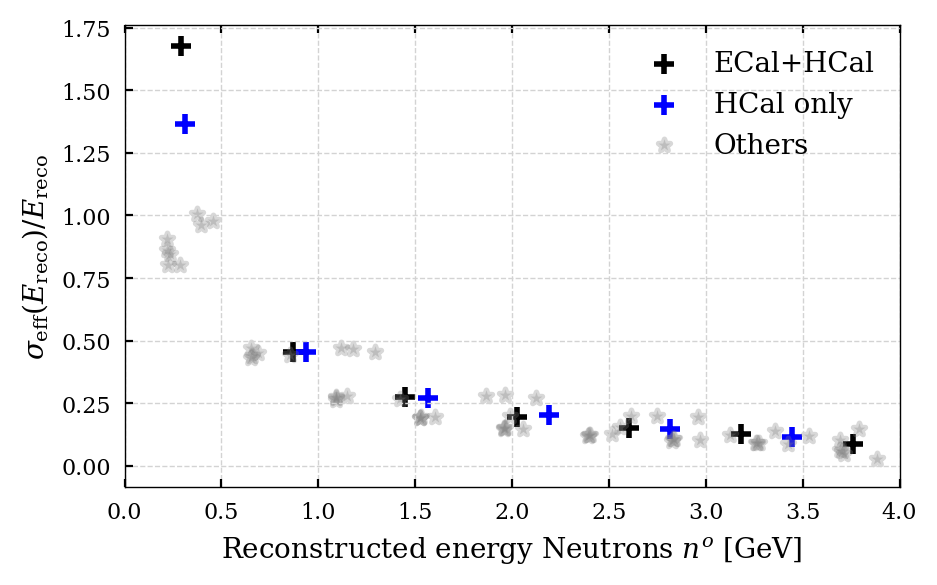

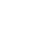

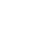

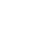

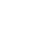

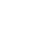

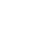

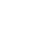

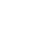

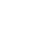

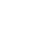

In [10]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
part_particles_list = [neutrons, neutrons_hcal]
plot_erg_resolution(fig, ax, part_particles_list[0], color='black', label='ECal+HCal', dict_label='neutron')
plot_erg_resolution(fig, ax, part_particles_list[1], color='blue', label='HCal only')
plot_reg_resolution_others(fig, ax, part_particles_list)
plt.show()

(9965,) (9965,)
(9965,) (9965,)
(10000,) (10000,)
(10000,) (10000,)
(10000,) (10000,)
(10000,) (10000,)
(9378,) (9378,)
(9378,) (9378,)
(9999,) (9999,)
(9998,) (9998,)
(9881,) (9881,)
(9833,) (9833,)
(9999,) (9999,)
(9999,) (9999,)
(9873,) (9873,)
(9872,) (9872,)
(10000,) (10000,)
(9999,) (9999,)
(9902,) (9902,)
(9845,) (9845,)


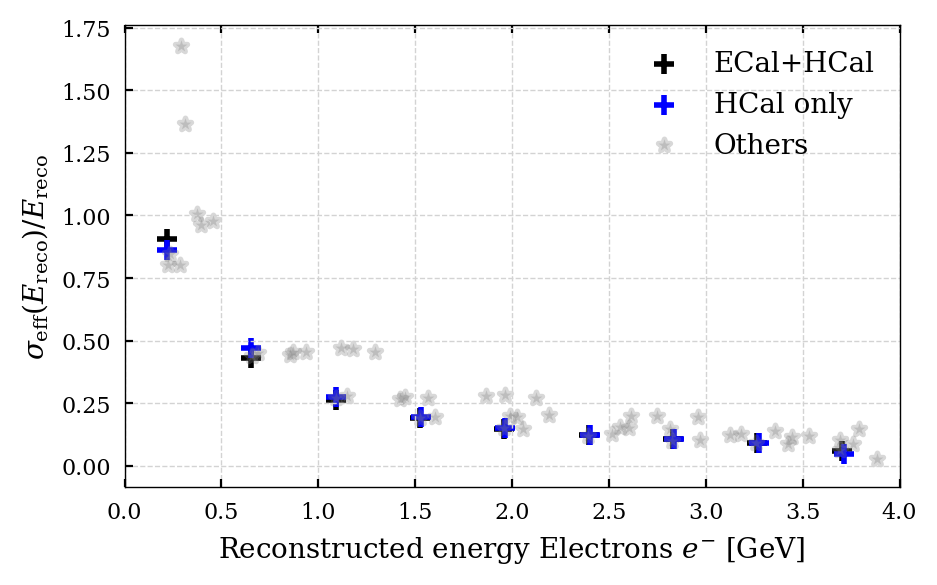

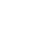

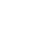

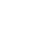

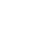

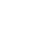

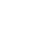

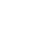

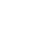

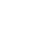

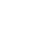

In [11]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
part_particles_list = [electrons, electrons_hcal]
plot_erg_resolution(fig, ax, part_particles_list[0], color='black', label='ECal+HCal', dict_label='electron')
plot_erg_resolution(fig, ax, part_particles_list[1], color='blue', label='HCal only')
plot_reg_resolution_others(fig, ax, part_particles_list)
plt.show()

(9378,) (9378,)
(9378,) (9378,)
(10000,) (10000,)
(10000,) (10000,)
(10000,) (10000,)
(10000,) (10000,)
(9965,) (9965,)
(9965,) (9965,)
(9999,) (9999,)
(9998,) (9998,)
(9881,) (9881,)
(9833,) (9833,)
(9999,) (9999,)
(9999,) (9999,)
(9873,) (9873,)
(9872,) (9872,)
(10000,) (10000,)
(9999,) (9999,)
(9902,) (9902,)
(9845,) (9845,)


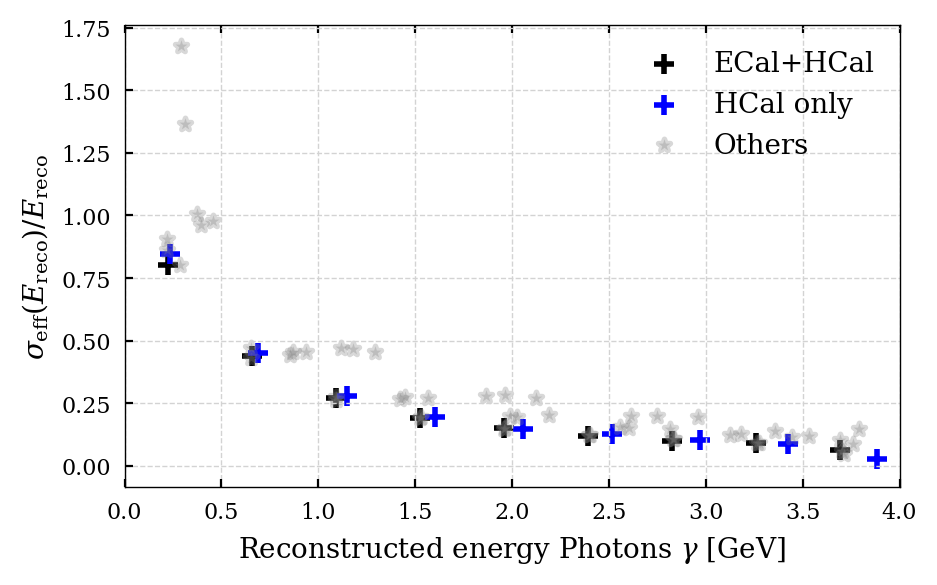

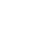

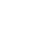

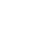

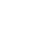

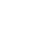

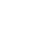

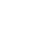

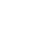

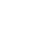

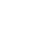

In [12]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
part_particles_list = [photons, photons_hcal]
plot_erg_resolution(fig, ax, part_particles_list[0], color='black', label='ECal+HCal', dict_label='photon')
plot_erg_resolution(fig, ax, part_particles_list[1], color='blue', label='HCal only')
plot_reg_resolution_others(fig, ax, part_particles_list)
plt.show()

(9873,) (9873,)
(9872,) (9872,)
(9999,) (9999,)
(9999,) (9999,)
(10000,) (10000,)
(10000,) (10000,)
(9965,) (9965,)
(9965,) (9965,)
(10000,) (10000,)
(10000,) (10000,)
(9378,) (9378,)
(9378,) (9378,)
(9999,) (9999,)
(9998,) (9998,)
(9881,) (9881,)
(9833,) (9833,)
(10000,) (10000,)
(9999,) (9999,)
(9902,) (9902,)
(9845,) (9845,)


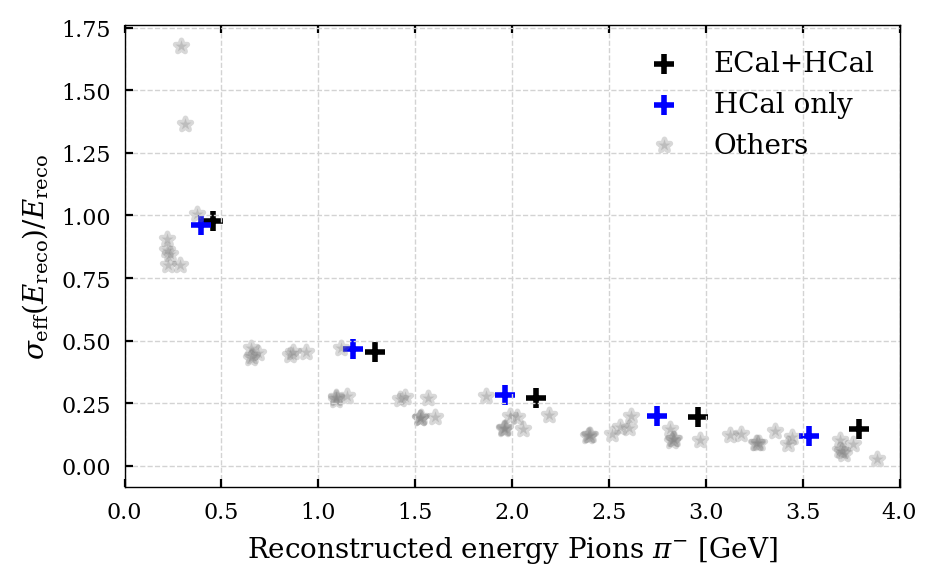

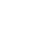

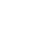

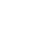

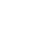

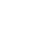

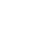

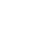

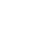

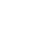

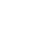

In [13]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
part_particles_list = [pions, pions_hcal]
plot_erg_resolution(fig, ax, part_particles_list[0], color='black', label='ECal+HCal', dict_label='pion')
plot_erg_resolution(fig, ax, part_particles_list[1], color='blue', label='HCal only')
plot_reg_resolution_others(fig, ax, part_particles_list)
plt.show()

(9902,) (9902,)
(9845,) (9845,)
(10000,) (10000,)
(9999,) (9999,)
(10000,) (10000,)
(10000,) (10000,)
(9965,) (9965,)
(9965,) (9965,)
(10000,) (10000,)
(10000,) (10000,)
(9378,) (9378,)
(9378,) (9378,)
(9999,) (9999,)
(9998,) (9998,)
(9881,) (9881,)
(9833,) (9833,)
(9999,) (9999,)
(9999,) (9999,)
(9873,) (9873,)
(9872,) (9872,)


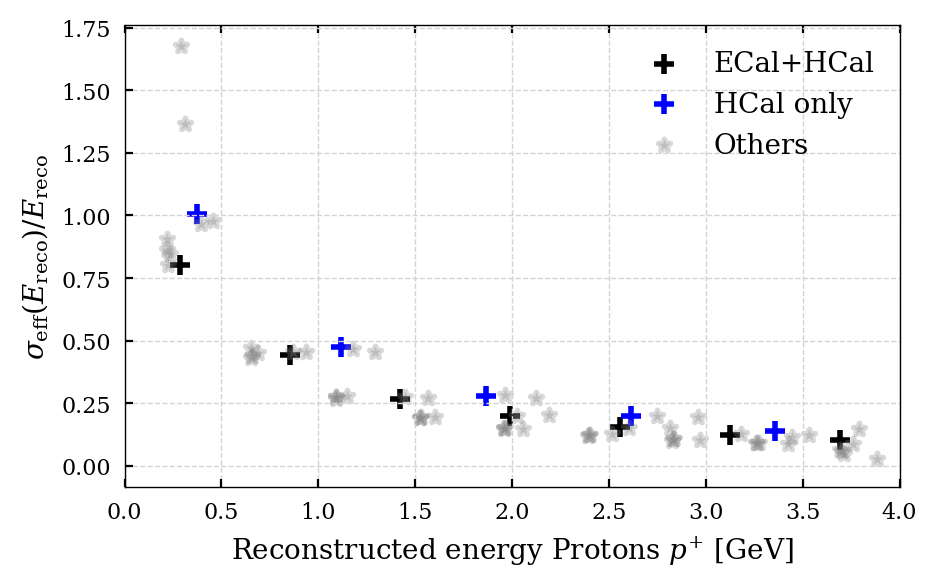

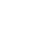

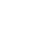

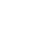

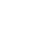

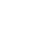

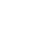

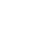

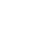

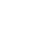

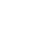

In [14]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
part_particles_list = [protons, protons_hcal]
plot_erg_resolution(fig, ax, part_particles_list[0], color='black', label='ECal+HCal', dict_label='proton')
plot_erg_resolution(fig, ax, part_particles_list[1], color='blue', label='HCal only')
plot_reg_resolution_others(fig, ax, part_particles_list)
plt.show()

## Truth Energy Bins

In [15]:
# bin the reconstructed energy data by truth energy
# plot by mean reconstructed energy

def plot_erg_resolution(fig, ax, particles, marker='+', color='slateblue', bin_num=20, hcal_flag=False,
                        size=50, alpha=1, label='', dict_label=None, verbose=True):
    import scipy.stats as stats
    plotting.style_ldmx(fig, ax)
    
    # the two energies
    # set the truth energy
    if hcal_flag:
        erg_truth = particles.get('PFTruthHcal_energy')  # the pre-hcal energy is set to truth
    else:
        # if the particle went through both ecal and hcal
        erg_truth = particles.get('PFTruthTarget_energy')  # the pre-target energy is set to truth
    erg_recon = particles.get('PFCandidates_energy_o1corr')
    # filter outliers
    erg_truth, erg_recon = plotting._clean_data(erg_truth, erg_recon)
    #(erg_truth, erg_recon), (_, _) = plotting.outlier_IQR(erg_truth, erg_recon)
    
    # bin the reconstructed energy by truth energy
    bin_min = 0
    bin_max = np.nanmax(erg_truth) if np.nanmax(erg_truth) < 4e3 else 4e3
    truth_bins = np.linspace(bin_min, bin_max, bin_num)  # bins
    
    # define percentile functions
    def _16(arr): return np.quantile(arr, .159) # sigma CI
    def _84(arr): return np.quantile(arr, .841)
    recon_med = stats.binned_statistic(erg_truth, erg_recon, statistic=np.median, bins=truth_bins)[0]  # median
    recon_mean = stats.binned_statistic(erg_truth, erg_recon, statistic=np.mean, bins=truth_bins)[0]  # mean
    # bin the reconstructed energies
    recon_16 = stats.binned_statistic(erg_truth, erg_recon, statistic=_16, bins=truth_bins)[0]  # percentiles
    recon_84 = stats.binned_statistic(erg_truth, erg_recon, statistic=_84, bins=truth_bins)[0]
    truth_bins_avg = [(a + b) / 2 for a, b in zip(truth_bins[::], truth_bins[1::])]  # average of two consecutive elements in bins
    
    # sigma value
    recon_sigma = recon_84 - recon_16
    recon_sigma = np.mean([recon_84 - recon_med, recon_med - recon_16], axis=0)
    
    # plot the binned distributions
    if verbose and dict_label is not None:
        _, ax_ = plt.subplots(figsize=(5, 3), dpi=200)
        # scatter if smaller than bin size
        truth_hist, truth_edges = np.histogram(erg_truth, bins=truth_bins) # histogram of data
        truth_bin_size = truth_edges[1] - truth_edges[0]
        
        # sort both with the same index
        truth_sortind = np.argsort(erg_truth).astype(int)
        truth_sort = np.array(erg_truth)[truth_sortind]
        recon_sort = np.array(erg_recon)[truth_sortind]
        
        bin_num = 0 # index of x and y to scatter
        for i, truth_bin in enumerate(truth_hist):
            # get the values within the bin
            x_bin = truth_sort[bin_num: bin_num+truth_bin]
            y_bin = recon_sort[bin_num: bin_num+truth_bin]
            
            # plot the at the average of the bin
#             x_med = np.median(x_bin)  # median of truth
#             x_med = np.array(truth_bins_avg)[i]  # bin location of truth
            x_med = recon_med[i]  # median of reconstructed
    
#             print((np.quantile(y_bin, .841) - np.median(y_bin))/x_med)
            ax_.boxplot([y_bin/1e3], positions=[x_med/1e3], vert=True, labels=[i],
                        showmeans=True, meanline=True, showfliers=False, notch=True, bootstrap=1000)
            xlim = [0, 4]
            ax_.set_xlim(xlim)
            ax_.set_xticks(np.arange(xlim[0], xlim[1]+0.5, 0.5), np.arange(xlim[0], xlim[1]+0.5, 0.5))
            ax_.set_ylim([0, 6])
            
            # add the number of elements in this bin
            bin_num += truth_bin
        
        ax_.annotate(text=labels_dict[dict_label], xy=(-50, -30), xycoords='axes points', fontsize=10, weight='bold')
        ax_.set_xlabel(f'Reconstructed energy bins', fontsize=10)
        ax_.set_ylabel(f'Reconstructed energies [GeV]', fontsize=10)
    
    # make the scatter plot
    x = np.array(recon_med)/1e3  # reconstructed
    y = recon_sigma/recon_med
    ax.scatter(x=x, y=y, marker=marker, s=size, lw=2, alpha=alpha, color=color, label=label)
    if dict_label is not None:
        ax.annotate(text=labels_dict[dict_label], xy=(-50, -30), xycoords='axes points', fontsize=10, weight='bold')
        ax.set_xlabel('Reconstructed energy [GeV]', fontsize=10)
        ax.set_ylabel(r'${\sigma_{\rm eff}(E_{\rm reco})} / {E_{\rm reco}}$', fontsize=10)
    ax.set_xlim([0, 4])
    ax.legend(fontsize=10)
    return y


full_particles_list = [
    electrons_hcal, electrons,
    photons_hcal, photons,
    neutrons_hcal, neutrons,
    pions_hcal, pions,
    protons_hcal, protons
]

def plot_reg_resolution_others(fig, ax, particles_list):
    other_particles_list = []
    for particles in full_particles_list:
        # add every particle not in the list to plot
        if particles not in particles_list:
            other_particles_list.append(particles)
    
    # label the first particle, which is hcal
    plot_erg_resolution(fig, ax, other_particles_list[0], marker='*', color='grey', size=20, alpha=0.3, verbose=False, label='Others', hcal_flag=True)
    # ecal+hcal particles
    for particles in other_particles_list[1::2]:
        plot_erg_resolution(fig, ax, particles, marker='*', color='grey', size=20, verbose=False, alpha=0.3, hcal_flag=False)
    # hcal particles
    for particles in other_particles_list[2::2]:
        plot_erg_resolution(fig, ax, particles, marker='*', color='grey', size=20, verbose=False, alpha=0.3, hcal_flag=True)

### Neutrons

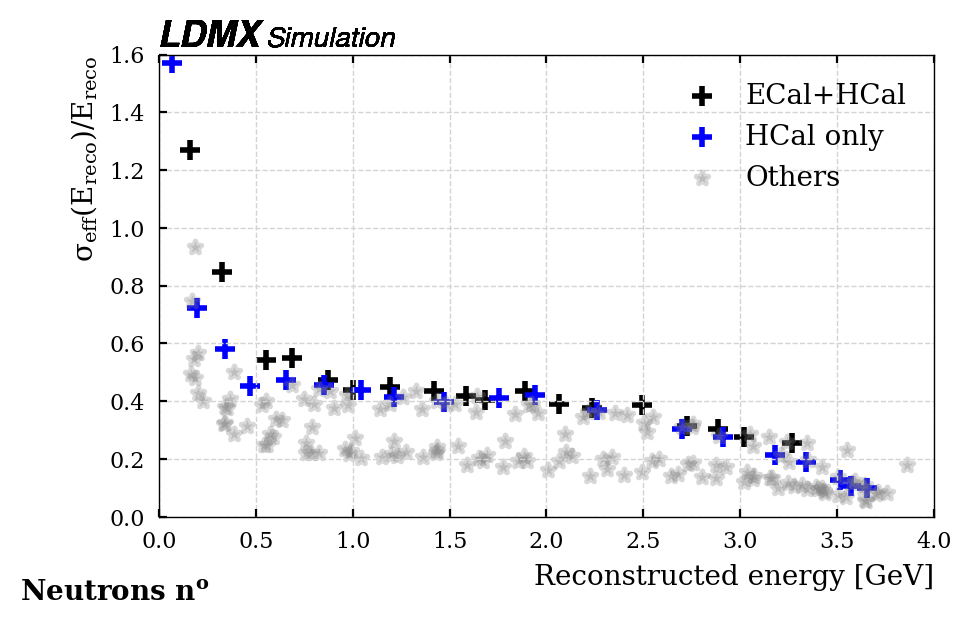

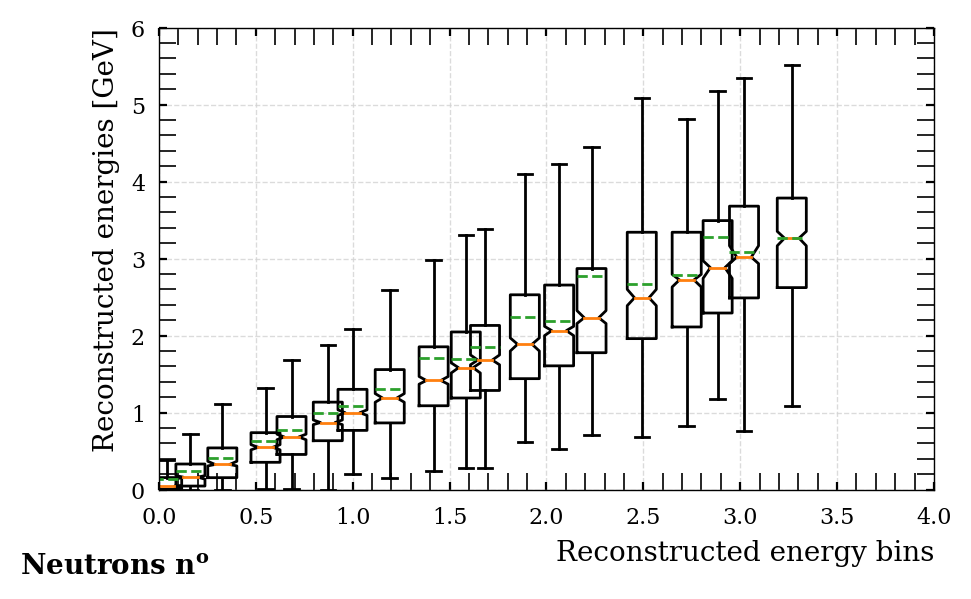

In [16]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
part_particles_list = [neutrons, neutrons_hcal]
plot_erg_resolution(fig, ax, part_particles_list[0], color='black', label='ECal+HCal', dict_label='neutron')
plot_erg_resolution(fig, ax, part_particles_list[1], color='blue', label='HCal only', hcal_flag=True)
plot_reg_resolution_others(fig, ax, part_particles_list)
ax.set_ylim(0, 1.6)
plt.show()

### Electrons

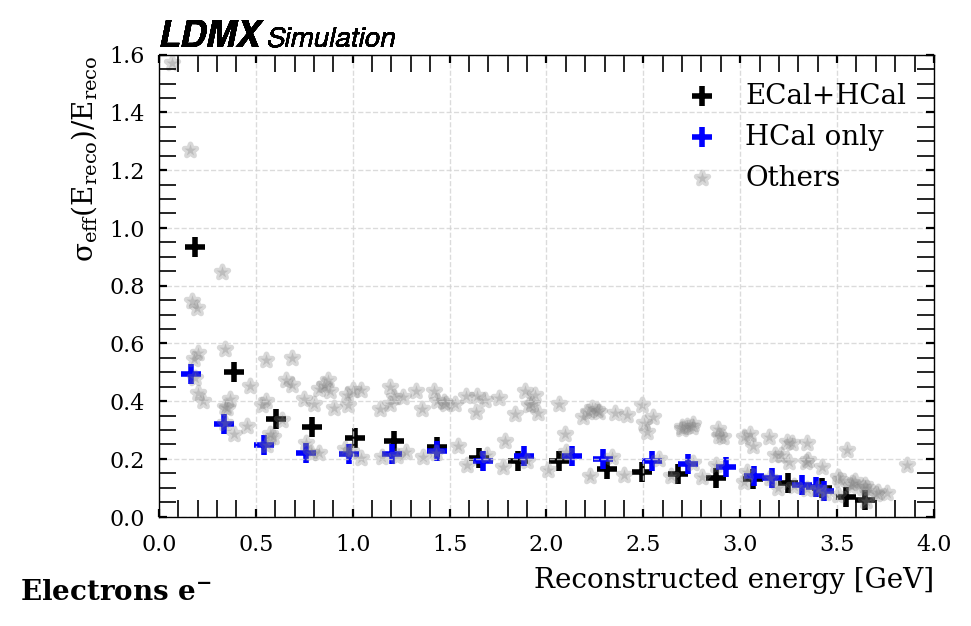

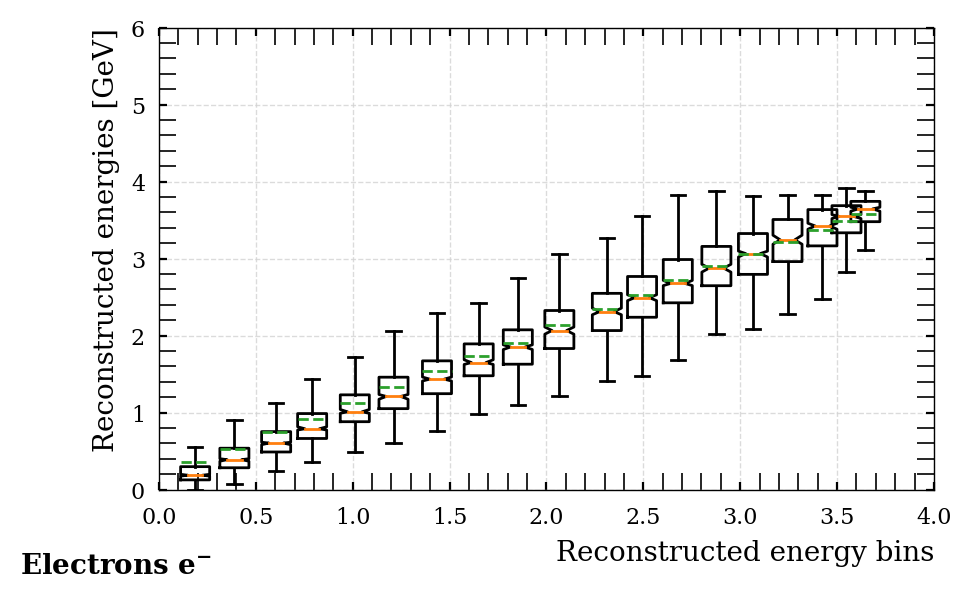

In [17]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
part_particles_list = [electrons, electrons_hcal]
plot_erg_resolution(fig, ax, part_particles_list[0], color='black', label='ECal+HCal', dict_label='electron')
plot_erg_resolution(fig, ax, part_particles_list[1], color='blue', label='HCal only', hcal_flag=True)
plot_reg_resolution_others(fig, ax, part_particles_list)
ax.set_ylim(0, 1.6)
plt.show()

### Photons

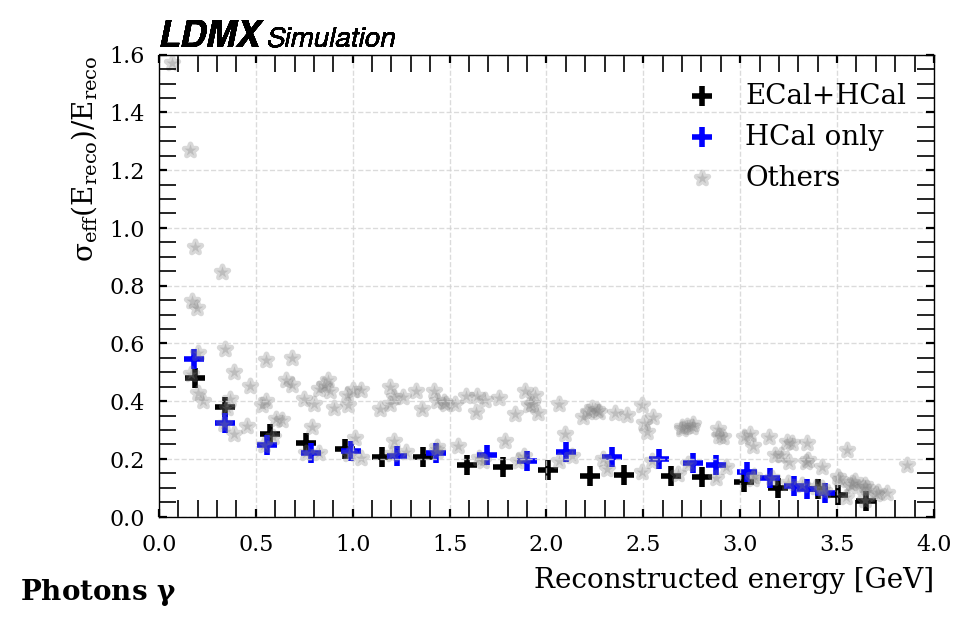

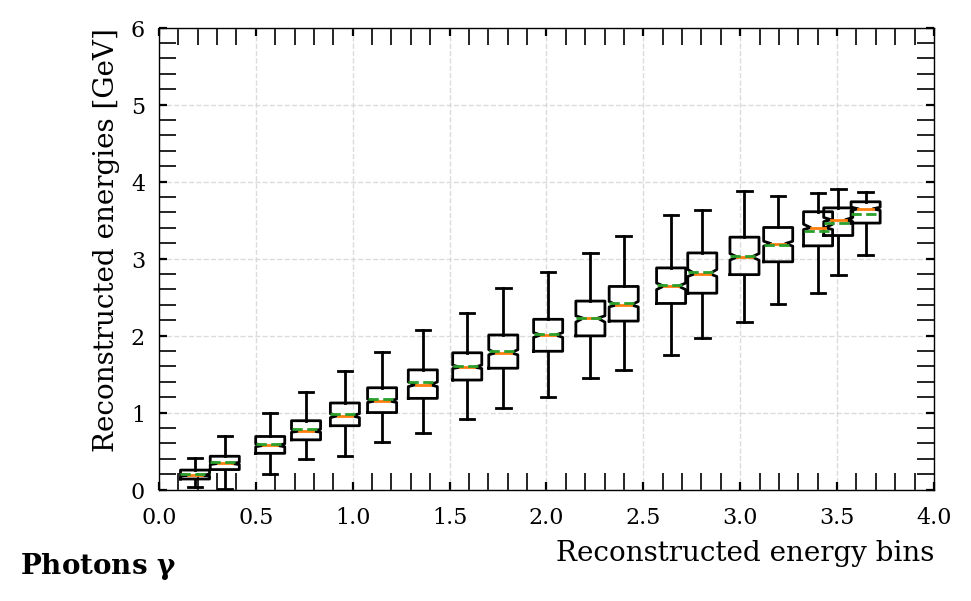

In [18]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
part_particles_list = [photons, photons_hcal]
plot_erg_resolution(fig, ax, part_particles_list[0], color='black', label='ECal+HCal', dict_label='photon')
plot_erg_resolution(fig, ax, part_particles_list[1], color='blue', label='HCal only', hcal_flag=True)
plot_reg_resolution_others(fig, ax, part_particles_list)
ax.set_ylim(0, 1.6)
plt.show()

### Pions

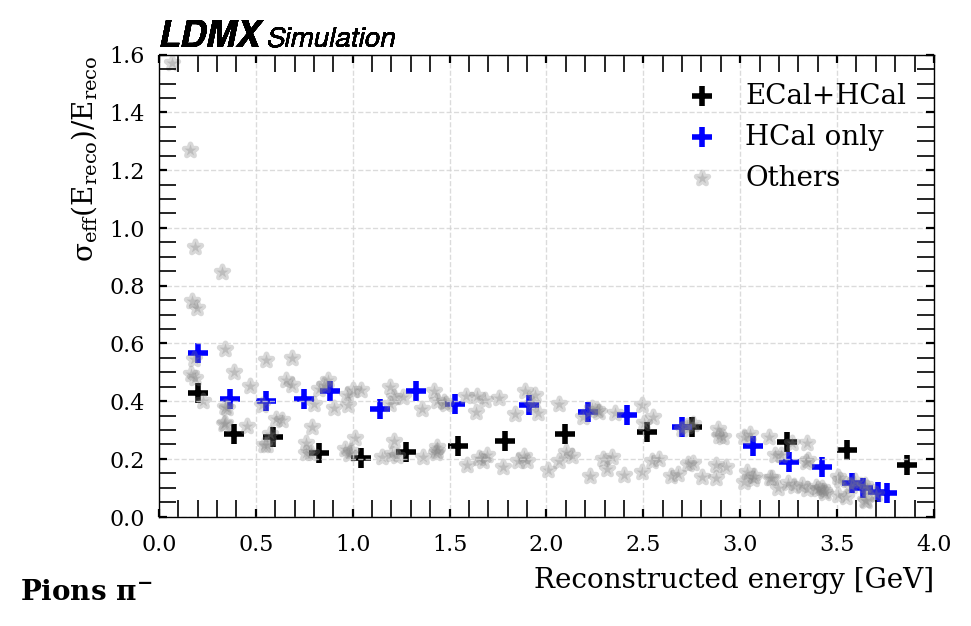

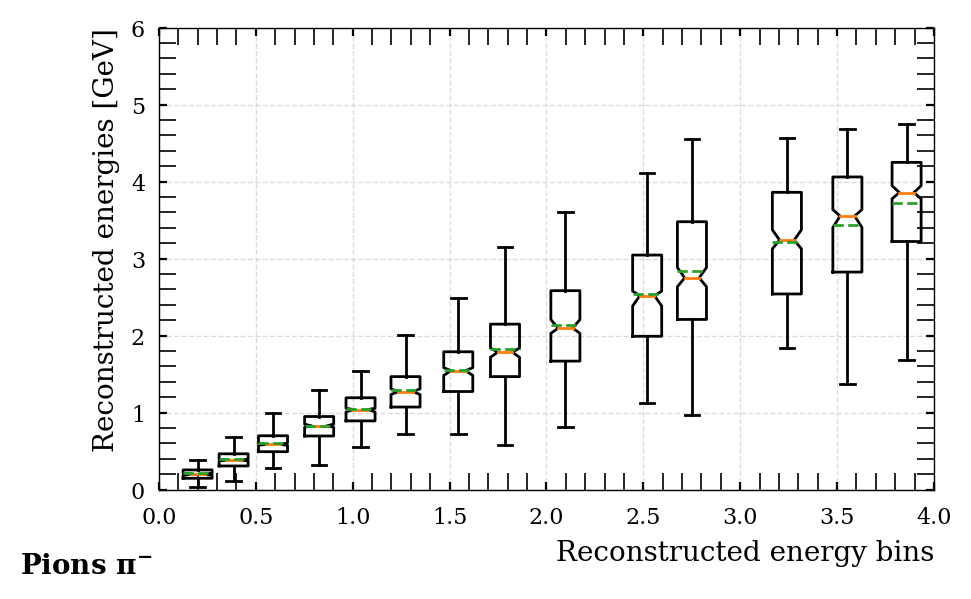

In [19]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
part_particles_list = [pions, pions_hcal]
plot_erg_resolution(fig, ax, part_particles_list[0], color='black', label='ECal+HCal', dict_label='pion')
plot_erg_resolution(fig, ax, part_particles_list[1], color='blue', label='HCal only', hcal_flag=True)
plot_reg_resolution_others(fig, ax, part_particles_list)
ax.set_ylim(0, 1.6)
plt.show()

### Protons

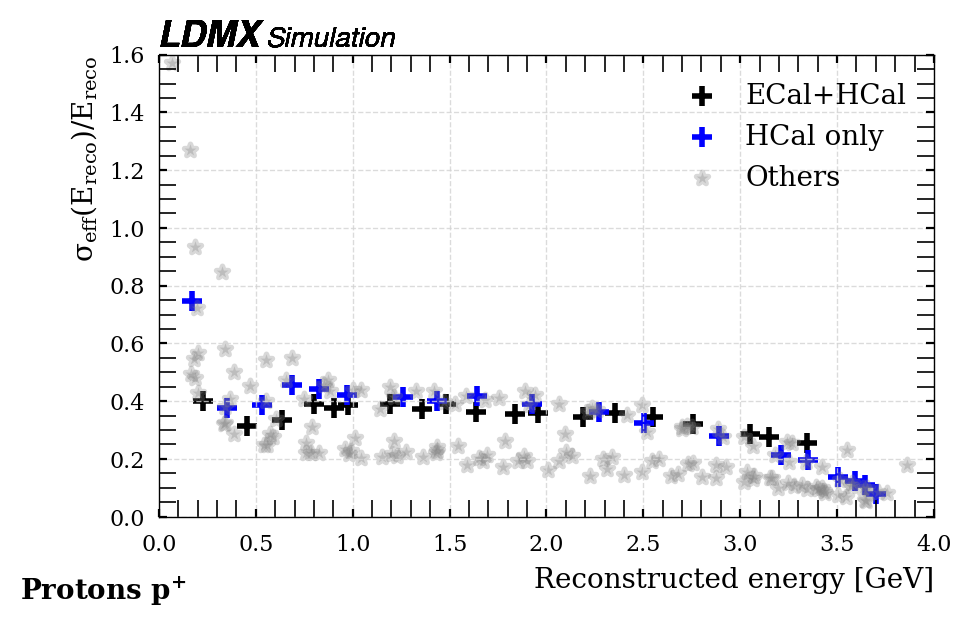

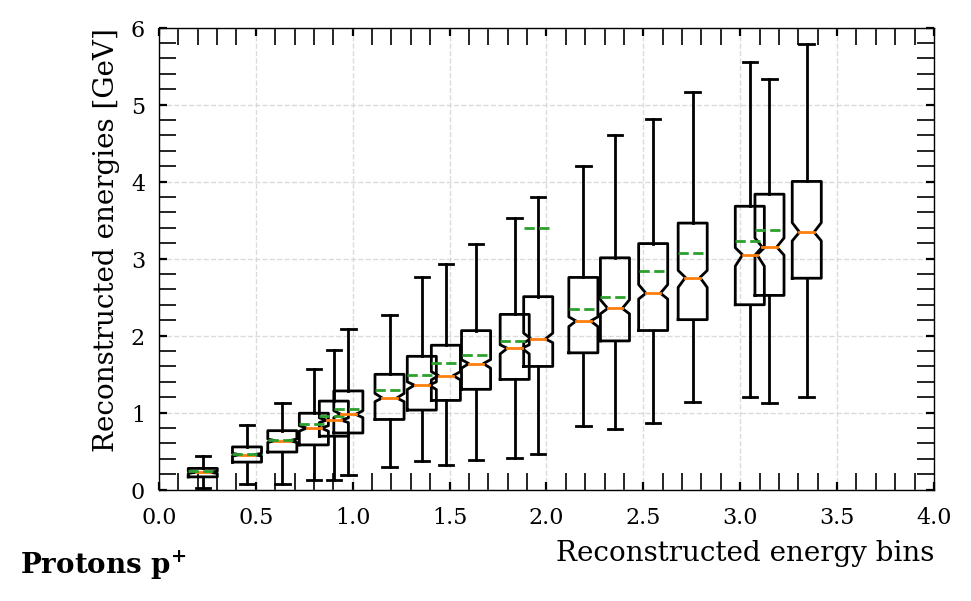

In [20]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
part_particles_list = [protons, protons_hcal]
plot_erg_resolution(fig, ax, part_particles_list[0], color='black', label='ECal+HCal', dict_label='proton')
plot_erg_resolution(fig, ax, part_particles_list[1], color='blue', label='HCal only', hcal_flag=True)
plot_reg_resolution_others(fig, ax, part_particles_list)
ax.set_ylim(0, 1.6)
plt.show()

## Energy Resolution Comparison

Protons, 3-4 GeV truth energy, energies ecal, hcal, and total

In [23]:
def plot_erg_dist(part, binwidth=0.1, dict_label=None, erg_min=0, erg_max=4, xlim=[0, 5], ylim=[0, 100]):
    import seaborn as sns
    from jason import jason_plotting as plotting
    
    # define the energies
    if (dict_label is not None) and ('hcal' in dict_label):
        # if the particle only went through hcal
        tot_erg = part.get('PFTruthHcal_energy')  # the pre-hcal energy is set to truth
    else:
        tot_erg = part.get('PFTruthTarget_energy')  # the pre-target energy is set to truth
    erg_mask = np.logical_and(tot_erg/1e3 > erg_min,
                              tot_erg/1e3 < erg_max)
    ecal = part.get('PFCandidates_ecalEnergy_o1corr')[erg_mask]/1e3
    hcal = part.get('PFCandidates_hcalEnergy_o1corr')[erg_mask]/1e3
    total = part.get('PFCandidates_energy_o1corr')[erg_mask]/1e3
    
    fig, ax = plt.subplots(figsize=(5, 2), dpi=200)
    plotting.hist(fig, ax, data=[ecal, hcal, total],
                  labels=['ECal', 'HCal', 'Total'], xlim=xlim, ylim=ylim, binwidth=binwidth,
                  draw_median=True, draw_quartiles=True,
                  xlabel='Calibrated Energy [GeV]', ylabel='Density')
    ax.set_title(f'Truth energy between {erg_min} and {erg_max} GeV')
    if dict_label is not None:
        ax.annotate(text=labels_dict[dict_label], xy=(-50, -30), xycoords='axes points', fontsize=10, weight='bold')
    ax.legend()
    plt.show()

### Pions

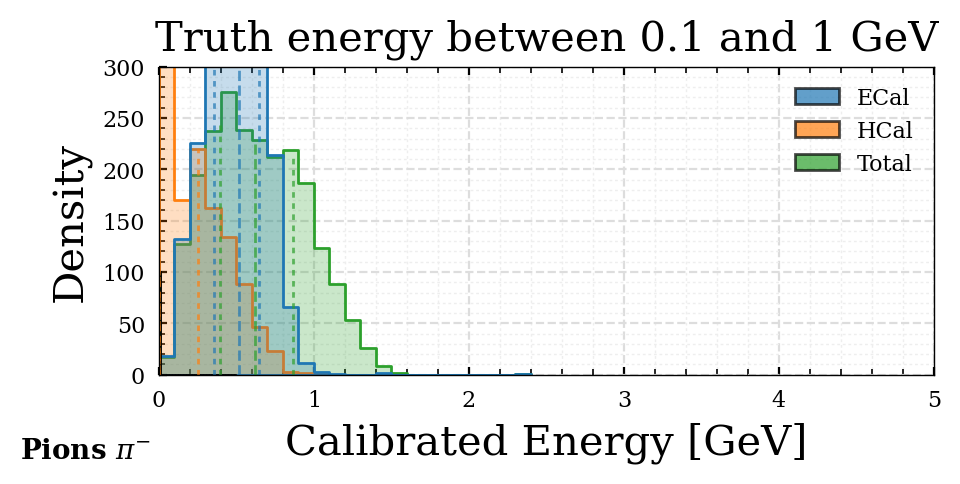

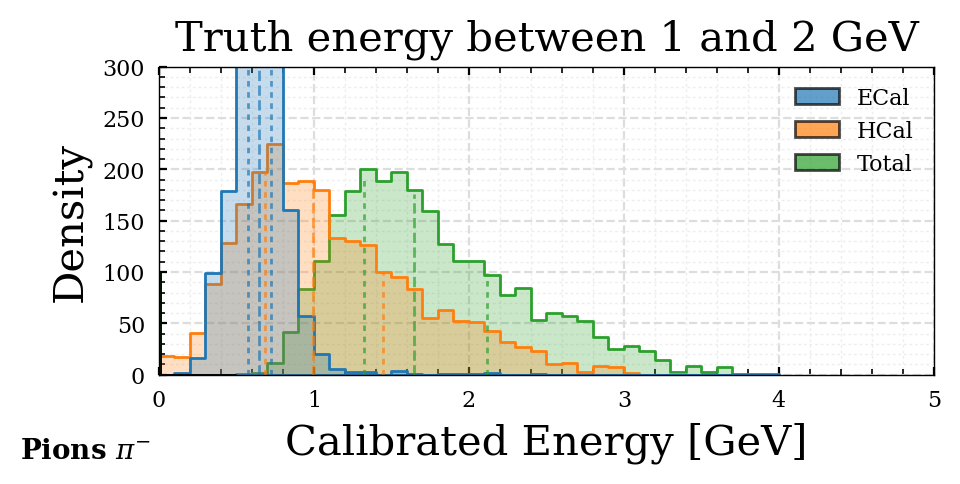

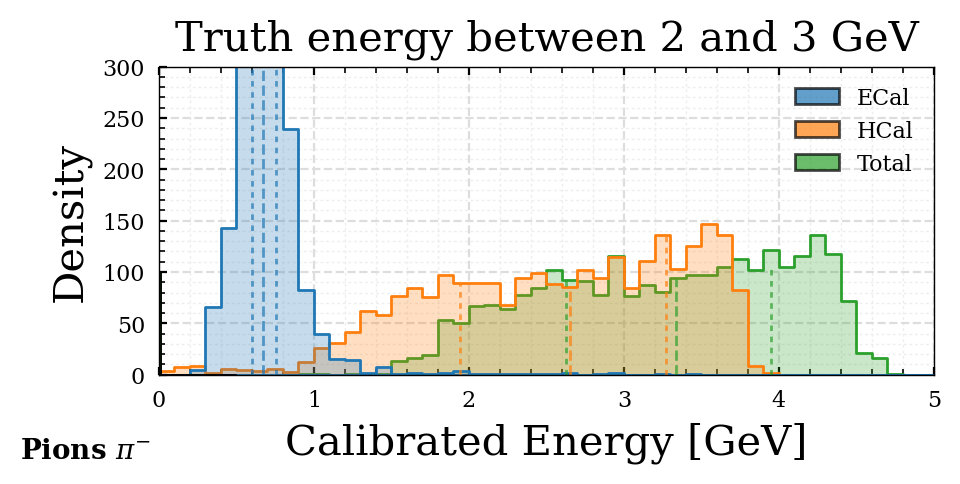

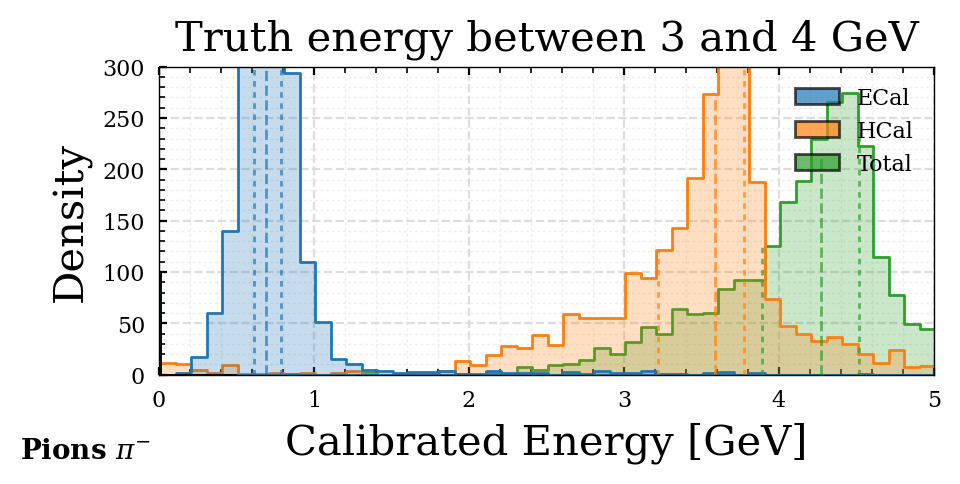

In [24]:
plot_erg_dist(pions, 0.1, 'pion', 0.1, 1, ylim=[0, 300])
plot_erg_dist(pions, 0.1, 'pion', 1, 2, ylim=[0, 300])
plot_erg_dist(pions, 0.1, 'pion', 2, 3, ylim=[0, 300])
plot_erg_dist(pions, 0.1, 'pion', 3, 4, ylim=[0, 300])

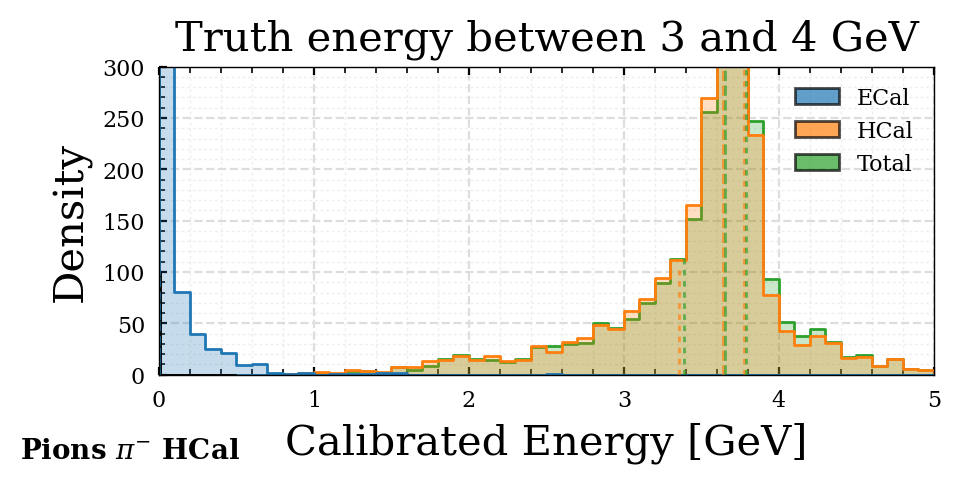

In [25]:
plot_erg_dist(pions_hcal, 0.1, 'pion_hcal', 3, 4, ylim=[0, 300])

### Protons

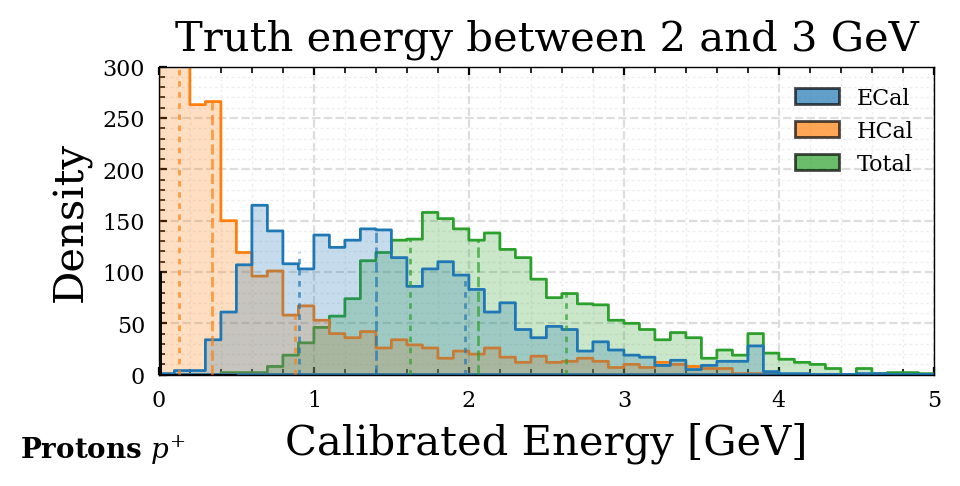

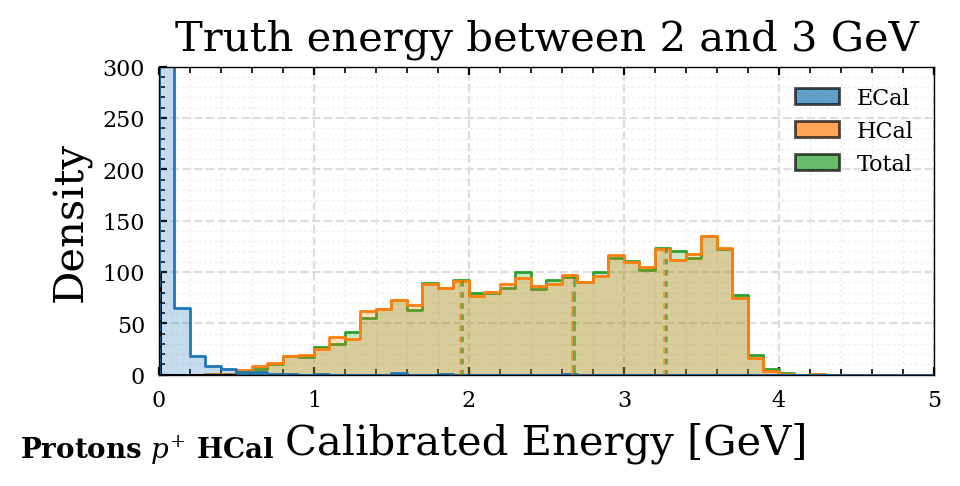

In [26]:
plot_erg_dist(protons, 0.1, 'proton', 2, 3, ylim=[0, 300])
plot_erg_dist(protons_hcal, 0.1, 'proton_hcal', 2, 3, ylim=[0, 300])

### Electrons

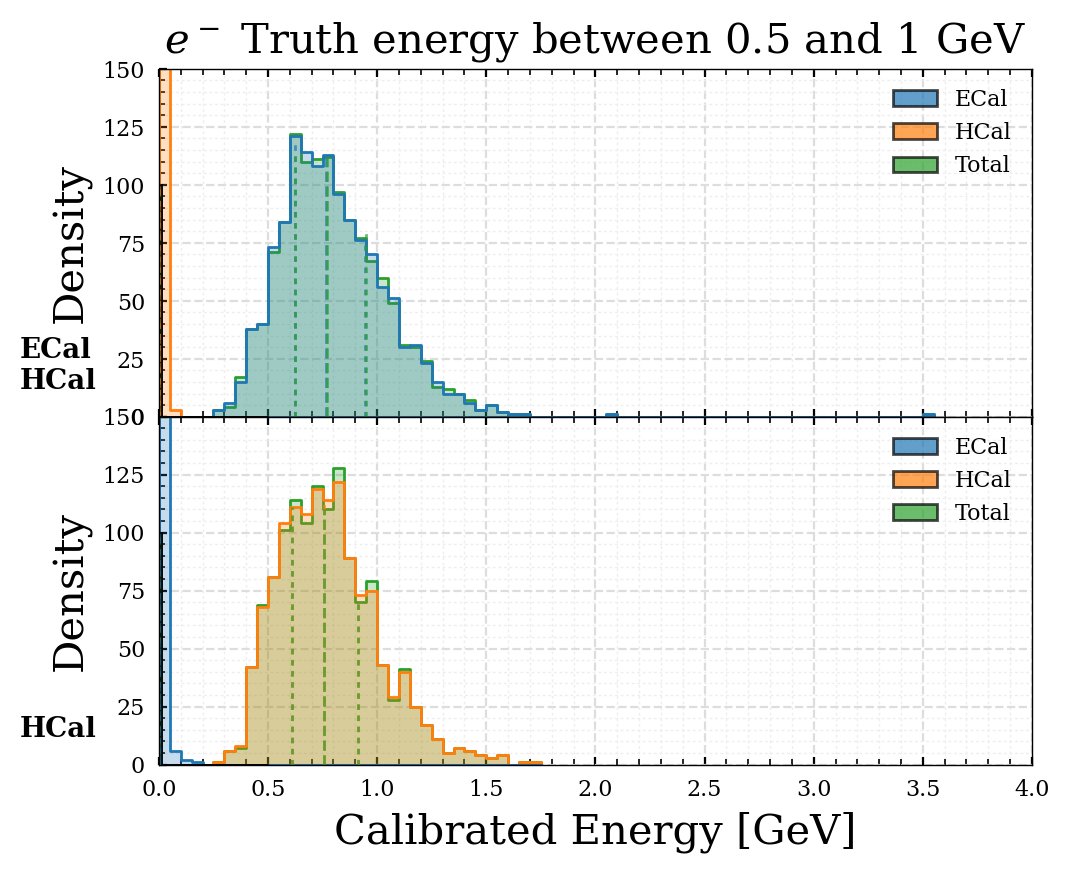

In [61]:
binwidth=0.05
erg_min=0.5; erg_max=1
xlim=[0, 4]
ylim=[0, 150]



import seaborn as sns
from jason import jason_plotting as plotting
fig, axs = plt.subplots(2, figsize=(5, 4), dpi=200, sharex=True, squeeze=True)
fig.tight_layout()

# define the energies
part = electrons
tot_erg = part.get('Sim_energy')
erg_mask = np.logical_and(tot_erg/1e3 > erg_min,
                          tot_erg/1e3 < erg_max)
ecal = part.get('PFCandidates_ecalEnergy_o1corr')[erg_mask]/1e3
hcal = part.get('PFCandidates_hcalEnergy_o1corr')[erg_mask]/1e3
total = part.get('PFCandidates_energy_o1corr')[erg_mask]/1e3

plotting.hist(fig, axs[0], data=[ecal, hcal, total],
              labels=['ECal', 'HCal', 'Total'], xlim=xlim, ylim=ylim, binwidth=binwidth,
              draw_median=True, draw_quartiles=True,
              xlabel='', ylabel='Density')
axs[0].set_title(fr'$e^-$ Truth energy between {erg_min} and {erg_max} GeV')
axs[0].annotate(text='ECal\nHCal', xy=(-50, 10), xycoords='axes points', fontsize=10, weight='bold')
axs[0].legend()



# define the energies
part = electrons_hcal
tot_erg = part.get('Sim_energy')
erg_mask = np.logical_and(tot_erg/1e3 > erg_min,
                          tot_erg/1e3 < erg_max)
ecal = part.get('PFCandidates_ecalEnergy_o1corr')[erg_mask]/1e3
hcal = part.get('PFCandidates_hcalEnergy_o1corr')[erg_mask]/1e3
total = part.get('PFCandidates_energy_o1corr')[erg_mask]/1e3

plotting.hist(fig, axs[1], data=[ecal, hcal, total],
              labels=['ECal', 'HCal', 'Total'], xlim=xlim, ylim=ylim, binwidth=binwidth,
              draw_median=True, draw_quartiles=True,
              xlabel='Calibrated Energy [GeV]', ylabel='Density')
axs[1].annotate(text='HCal', xy=(-50, 10), xycoords='axes points', fontsize=10, weight='bold')
axs[1].legend()

plt.subplots_adjust(hspace=.0)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Axes limits [0, 4000.0] and [0, 4000.0]


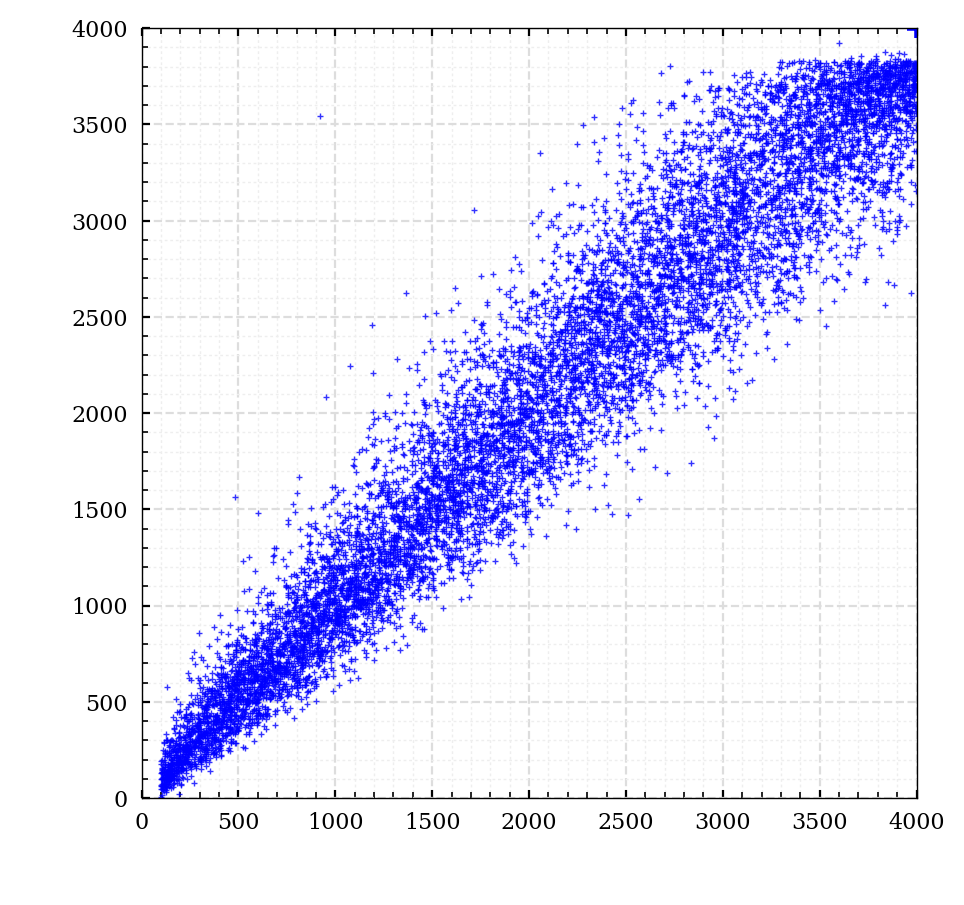

In [59]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=200)
plotting.scatter(fig, ax, electrons.get('Sim_energy'), electrons.get('PFCandidates_energy_o1corr'),
                 xlim=[0, 4e3], ylim=[0, 4e3])
plt.show()

### Energy makeups

In [ ]:
def part_comp(part, erg_low=0, erg_high=4):
    return np.logical_and(part.get('PFTruthTarget_energy')/1e3 > erg_low,
                          part.get('PFTruthTarget_energy')/1e3 < erg_high)

#### Protons: spread at high ecal

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)

quant = [
    protons.get('PFCandidates_ecalEnergy_o1corr')[part_comp(protons, 3, 4)]/1e3,
    protons.get('PFCandidates_ecalEnergy_o1corr')[part_comp(protons, 2, 3)]/1e3,
    protons.get('PFCandidates_ecalEnergy_o1corr')[part_comp(protons, 1, 2)]/1e3,
    protons.get('PFCandidates_ecalEnergy_o1corr')[part_comp(protons, 0, 1)]/1e3
]
labels = ['Truth 3+ GeV', '2-3 GeV', '1-2 GeV', '0-1 GeV']
plotting.hist(fig, ax, quant, labels, binwidth=0.1,
              xlim=[0, 5], ylim=[0, 410],
              draw_median=True, draw_quartiles=True,
              xlabel=f'{labels_dict["proton"]} ecal reconstructed erg [GeV]', ylabel='Density')
# ax.set_yscale('log')
ax.legend(loc='upper center')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
quant = [
    protons.get('PFCandidates_ecalEnergy')[part_comp(protons, 3, 4)]/1e3,
    protons.get('PFCandidates_ecalEnergy')[part_comp(protons, 2, 3)]/1e3,
    protons.get('PFCandidates_ecalEnergy')[part_comp(protons, 1, 2)]/1e3,
    protons.get('PFCandidates_ecalEnergy')[part_comp(protons, 0, 1)]/1e3
]
labels = ['Truth 3+ GeV', '2-3 GeV', '1-2 GeV', '0-1 GeV']
plotting.hist(fig, ax, quant, labels, binwidth=0.1,
              xlim=[0, 5], ylim=[0, 410],
              draw_median=True, draw_quartiles=True,
              xlabel=f'{labels_dict["proton"]} ecal measured erg [GeV]', ylabel='Density')
# ax.set_yscale('log')
ax.legend(loc='upper center')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
quant = [
    protons.get('PFCandidates_hcalEnergy_o1corr')[part_comp(protons, 3, 4)]/1e3,
    protons.get('PFCandidates_hcalEnergy_o1corr')[part_comp(protons, 2, 3)]/1e3,
    protons.get('PFCandidates_hcalEnergy_o1corr')[part_comp(protons, 1, 2)]/1e3,
    protons.get('PFCandidates_hcalEnergy_o1corr')[part_comp(protons, 0, 1)]/1e3
]
labels = ['Truth 3+ GeV', '2-3 GeV', '1-2 GeV', '0-1 GeV']
plotting.hist(fig, ax, quant, labels, binwidth=0.1,
              xlim=[0, 5], ylim=[0, 410],
              draw_median=True, draw_quartiles=True,
              xlabel=f'{labels_dict["proton"]} hcal reconstructed erg [GeV]', ylabel='Density')
# ax.set_yscale('log')
ax.legend(loc='upper center')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
quant = [
    protons.get('PFCandidates_energy_o1corr')[part_comp(protons, 3, 4)]/1e3,
    protons.get('PFCandidates_energy_o1corr')[part_comp(protons, 2, 3)]/1e3,
    protons.get('PFCandidates_energy_o1corr')[part_comp(protons, 1, 2)]/1e3,
    protons.get('PFCandidates_energy_o1corr')[part_comp(protons, 0, 1)]/1e3
]
labels = ['Truth 3+ GeV', '2-3 GeV', '1-2 GeV', '0-1 GeV']
plotting.hist(fig, ax, quant, labels, binwidth=0.1,
              xlim=[0, 5], ylim=[0, 410],
              draw_median=True, draw_quartiles=True,
              xlabel=f'{labels_dict["proton"]} total reconstructed erg [GeV]', ylabel='Density')
# ax.set_yscale('log')
ax.legend(loc='upper center')
plt.show()

#### Electrons: spread at low ecal

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
quant = [
    electrons.get('PFCandidates_ecalEnergy_o1corr')[part_comp(electrons, 3, 4)]/1e3,
    electrons.get('PFCandidates_ecalEnergy_o1corr')[part_comp(electrons, 2, 3)]/1e3,
    electrons.get('PFCandidates_ecalEnergy_o1corr')[part_comp(electrons, 1, 2)]/1e3,
    electrons.get('PFCandidates_ecalEnergy_o1corr')[part_comp(electrons, 0, 1)]/1e3
]
labels = ['Truth 3+ GeV', '2-3 GeV', '1-2 GeV', '0-1 GeV']
plotting.hist(fig, ax, quant, labels, binwidth=0.1,
              xlim=[0, 4], ylim=[0, 410],
              draw_median=True, draw_quartiles=True,
              xlabel=f'{labels_dict["electron"]} ecal reconstructed erg [GeV]', ylabel='Density')
# ax.set_yscale('log')
ax.legend(loc='upper center')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
quant = [
    electrons.get('PFCandidates_ecalEnergy')[part_comp(electrons, 3, 4)]/1e3,
    electrons.get('PFCandidates_ecalEnergy')[part_comp(electrons, 2, 3)]/1e3,
    electrons.get('PFCandidates_ecalEnergy')[part_comp(electrons, 1, 2)]/1e3,
    electrons.get('PFCandidates_ecalEnergy')[part_comp(electrons, 0, 1)]/1e3
]
labels = ['Truth 3+ GeV', '2-3 GeV', '1-2 GeV', '0-1 GeV']
plotting.hist(fig, ax, quant, labels, binwidth=0.1,
              xlim=[0, 4], ylim=[0, 410],
              draw_median=True, draw_quartiles=True,
              xlabel=f'{labels_dict["electron"]} ecal measured erg [GeV]', ylabel='Density')
# ax.set_yscale('log')
ax.legend(loc='upper center')
plt.show()

#### Pions: double peak

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
quant = [
    pions.get('PFCandidates_energy_o1corr')[part_comp(pions, 3, 4)]/1e3,
    pions.get('PFCandidates_energy_o1corr')[part_comp(pions, 2, 3)]/1e3,
    pions.get('PFCandidates_energy_o1corr')[part_comp(pions, 1, 2)]/1e3,
    pions.get('PFCandidates_energy_o1corr')[part_comp(pions, 0, 1)]/1e3
]
labels = ['Truth 3+ GeV', '2-3 GeV', '1-2 GeV', '0-1 GeV']
plotting.hist(fig, ax, quant, labels, binwidth=0.1,
              xlim=[0, 5], ylim=[0, 410],
              draw_median=True, draw_quartiles=True,
              xlabel=f'{labels_dict["pion"]} hcal reconstructed erg [GeV]', ylabel='Density')
# ax.set_yscale('log')
ax.legend(loc='upper center')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
quant = [
    pions.get('PFCandidates_ecalEnergy_o1corr')[pions.get('PFTruthTarget_energy') > 3e3]/1e3,
    pions.get('PFCandidates_ecalEnergy_o1corr')[pions.get('PFTruthTarget_energy') > 2e3]/1e3,
    pions.get('PFCandidates_ecalEnergy_o1corr')[pions.get('PFTruthTarget_energy') > 1e3]/1e3,
    pions.get('PFCandidates_ecalEnergy_o1corr')/1e3
]
labels = ['Truth > 3GeV', '> 2GeV', '> 1GeV', 'All']
plotting.hist(fig, ax, quant, labels, binwidth=0.1,
              xlim=[0, 5], ylim=[0, 410],
              draw_median=True, draw_quartiles=True,
              xlabel=f'{labels_dict["pion"]} ecal reconstructed erg [GeV]', ylabel='Density')
# ax.set_yscale('log')
ax.legend(loc='upper center')
plt.show()

### Corrected energy makeups

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
quant = [
    electrons.get('PFCandidates_energy_o1corr')[electrons.get('PFTruthTarget_energy') > 3e3]/1e3,
    electrons.get('PFCandidates_energy_o1corr')[electrons.get('PFTruthTarget_energy') > 2e3]/1e3,
    electrons.get('PFCandidates_energy_o1corr')[electrons.get('PFTruthTarget_energy') > 1e3]/1e3,
    electrons.get('PFCandidates_energy_o1corr')/1e3
]
labels = ['Truth > 3GeV', '> 2GeV', '> 1GeV', 'All']
plotting.hist(fig, ax, quant, labels, binwidth=0.1,
              xlim=[0, 5], ylim=[0, 410],
              draw_median=True, draw_quartiles=True,
              xlabel=f'{labels_dict["electron"]} total reco erg [GeV]', ylabel='Density')
# ax.set_yscale('log')
ax.axvline(4, ls='-.', lw=1, color='black', alpha=0.5)
ax.legend(loc='upper center')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
quant = [
    electrons.get('PFCandidates_ecalEnergy')[electrons.get('PFTruthTarget_energy') > 3e3]/1e3,
    electrons.get('PFCandidates_ecalEnergy')[electrons.get('PFTruthTarget_energy') > 2e3]/1e3,
    electrons.get('PFCandidates_ecalEnergy')[electrons.get('PFTruthTarget_energy') > 1e3]/1e3,
    electrons.get('PFCandidates_ecalEnergy')/1e3
]
labels = ['Truth > 3GeV', '> 2GeV', '> 1GeV', 'All']
plotting.hist(fig, ax, quant, labels, binwidth=0.1,
              xlim=[0, 5], ylim=[0, 410],
              draw_median=True, draw_quartiles=True,
              xlabel=f'{labels_dict["electron"]} ecal measured erg [GeV]', ylabel='Density')
# ax.set_yscale('log')
ax.legend(loc='upper center')
plt.show()

## Energy response plots

`PFCandidates_energy_o1corr` / `PFTruthTarget_energy` in bins of reconstructed `PFTruthTarget_energy` for ecal+hcal particles

In [ ]:
# bin the reconstructed energy data by truth energy
# plot by mean reconstructed energy

def plot_erg_response(fig, ax, particles, marker='+', color='slateblue', bin_num=20, hcal_flag=False,
                      alpha=1, label='', dict_label=None, verbose=True):
    import scipy.stats as stats
    
    # the two energies
    # set the truth energy
    if hcal_flag:
        erg_truth = particles.get('PFTruthHcal_energy')  # the pre-hcal energy is set to truth
    else:
        # if the particle went through both ecal and hcal
        erg_truth = particles.get('PFTruthTarget_energy')  # the pre-target energy is set to truth
    erg_recon = particles.get('PFCandidates_energy_o1corr')
    # filter outliers
    erg_truth, erg_recon = plotting._clean_data(erg_truth, erg_recon)
    #(erg_truth, erg_recon), (_, _) = plotting.outlier_IQR(erg_truth, erg_recon)

    Y = erg_recon/erg_truth
    X = erg_truth/1e3
    
    # bin the reconstructed energy by truth energy
    bin_min = 0
    bin_max = np.nanmax(X) if np.nanmax(X) < 4 else 4
    truth_bins = np.linspace(bin_min, bin_max, bin_num)  # bins
    
    # define percentile functions
    def _16(arr): return np.quantile(arr, .159) # sigma CI
    def _84(arr): return np.quantile(arr, .841)
    # the median of reconstructed energy with each truth bin
    x_locs = stats.binned_statistic(X, erg_recon/1e3, statistic=np.median, bins=truth_bins)[0]  # median

    # the median and CI of reco/truth energies
    
    recon_med = stats.binned_statistic(X, Y, statistic=np.median, bins=truth_bins)[0]  # median
    recon_16 = stats.binned_statistic(X, Y, statistic=_16, bins=truth_bins)[0]  # percentiles
    recon_84 = stats.binned_statistic(X, Y, statistic=_84, bins=truth_bins)[0]

    # plot with error bars
    XY_medm = recon_med - recon_16
    XY_medp = recon_84 - recon_med
    # make line and error bar
    plotting.error_bar(_, plt.gca(), x=x_locs, y=recon_med, yerr=[XY_medm, XY_medp], ms=5, capsize=5, fmt='.-', color=color, label=label)
    
    # plot the bin size
    textpos = [3, 1.5]
    binwidth = truth_bins[1] - truth_bins[0]
    plt.hlines(y=textpos[1],
               xmin=textpos[0]-binwidth/2,
               xmax=textpos[0]+binwidth/2,
               color='black', lw=2, ls='--', zorder=2)
    plt.text(x=textpos[0], y=textpos[1]*1.05, s='Truth Bin Size', fontsize=10, alpha=0.8, ha='center')
                          
    # add extra elements
    ax.annotate(text=labels_dict[dict_label], xy=(-50, -30), xycoords='axes points', fontsize=10, weight='bold')
    ax.set_xlabel(f'Reconstructed energy [GeV]', fontsize=10)
    ax.set_ylabel(f'Reconstructed / Truth', fontsize=10)

### Particles

In [ ]:
part_particles_list = [neutrons, neutrons_hcal]
fig, ax = plt.subplots(figsize=(5, 2.5), dpi=200)

plot_erg_response(fig, ax, part_particles_list[0], color='black', label='ECal+HCal', dict_label='neutron')
ax.set_xlim(0, 4)
ax.set_ylim(0, 2)
plt.show()
fig, ax = plt.subplots(figsize=(5, 2.5), dpi=200)
plot_erg_response(fig, ax, part_particles_list[1], color='blue', label='HCal only', hcal_flag=True, dict_label='neutron_hcal')
ax.set_xlim(0, 4)
ax.set_ylim(0, 2)
plt.show()

In [ ]:
part_particles_list = [electrons, electrons_hcal]
fig, ax = plt.subplots(figsize=(5, 2.5), dpi=200)

plot_erg_response(fig, ax, part_particles_list[0], color='black', label='ECal+HCal', dict_label='electron')
ax.set_xlim(0, 4)
ax.set_ylim(0, 2)
plt.show()
fig, ax = plt.subplots(figsize=(5, 2.5), dpi=200)
plot_erg_response(fig, ax, part_particles_list[1], color='blue', label='HCal only', hcal_flag=True, dict_label='electron_hcal')
ax.set_xlim(0, 4)
ax.set_ylim(0, 2)
plt.show()

In [ ]:
part_particles_list = [photons, photons_hcal]
fig, ax = plt.subplots(figsize=(5, 2.5), dpi=200)

plot_erg_response(fig, ax, part_particles_list[0], color='black', label='ECal+HCal', dict_label='photon')
ax.set_xlim(0, 4)
ax.set_ylim(0, 2)
plt.show()
fig, ax = plt.subplots(figsize=(5, 2.5), dpi=200)
plot_erg_response(fig, ax, part_particles_list[1], color='blue', label='HCal only', hcal_flag=True, dict_label='photon_hcal')
ax.set_xlim(0, 4)
ax.set_ylim(0, 2)
plt.show()

### Investigating Pions

In [ ]:
part_particles_list = [pions, pions_hcal]
fig, ax = plt.subplots(figsize=(5, 2.5), dpi=200)

plot_erg_response(fig, ax, part_particles_list[0], color='black', label='ECal+HCal', dict_label='pion')
ax.set_xlim(0, 4)
ax.set_ylim(0, 2)
plt.show()
fig, ax = plt.subplots(figsize=(5, 2.5), dpi=200)
plot_erg_response(fig, ax, part_particles_list[1], color='blue', label='HCal only', hcal_flag=True, dict_label='pion_hcal')
ax.set_xlim(0, 4)
ax.set_ylim(0, 2)
plt.show()

In [ ]:
part_particles_list = [protons, protons_hcal]
fig, ax = plt.subplots(figsize=(5, 2.5), dpi=200)

plot_erg_response(fig, ax, part_particles_list[0], color='black', label='ECal+HCal', dict_label='proton')
ax.set_xlim(0, 4)
ax.set_ylim(0, 2)
plt.show()
fig, ax = plt.subplots(figsize=(5, 2.5), dpi=200)
plot_erg_response(fig, ax, part_particles_list[1], color='blue', label='HCal only', hcal_flag=True, dict_label='proton_hcal')
ax.set_xlim(0, 4)
ax.set_ylim(0, 2)
plt.show()